In [31]:
import requests
import time
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Descargar el HTML
url = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"
headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
}

try:
    response = requests.get(url, headers=headers)
    time.sleep(10)  # Pausa
    response.raise_for_status()
    html_data = response.text
    print("HTML descargado correctamente.")
except requests.exceptions.RequestException as e:
    print(f"Error al descargar el HTML: {e}")
    html_data = None

# Paso 2: Transformar HTML
def parse_html(html_data):
    """Convierte el HTML en un objeto BeautifulSoup."""
    if not html_data:
        raise ValueError("El contenido HTML está vacío o es None")
    return BeautifulSoup(html_data, "html.parser")

if html_data:
    soup = parse_html(html_data)
    tables = soup.find_all("table")
else:
    print("No se pudo descargar o procesar el HTML correctamente.")

# Paso 3: Extraer la tabla
def extract_tesla_revenue(tables):
    """Extrae los datos de la tabla de 'Tesla Quarterly Revenue' y los almacena en un DataFrame."""
    table_index = None
    for index, table in enumerate(tables):
        if "Tesla Quarterly Revenue" in str(table):
            table_index = index
            break

    if table_index is None:
        raise ValueError("No se encontró una tabla con información de ingresos trimestrales.")

    # Extraer datos
    tesla_revenue = []
    for row in tables[table_index].tbody.find_all("tr"):
        cols = row.find_all("td")
        if cols:
            date = cols[0].text.strip()
            revenue = cols[1].text.replace("$", "").replace(",", "").strip()

            # Validar y limpiar
            if revenue and "B" in revenue: 
                try:
                    revenue = float(revenue.replace("B", "")) * 1000
                except ValueError:
                    revenue = None
            elif revenue:  
                try:
                    revenue = float(revenue)
                except ValueError:
                    revenue = None
            else:
                revenue = None  

            tesla_revenue.append([date, revenue])

    # Convertir a DataFrame 
    df_tesla_revenue = pd.DataFrame(tesla_revenue, columns=["Date", "Revenue"])
    df_tesla_revenue["Date"] = pd.to_datetime(df_tesla_revenue["Date"], errors="coerce")
    df_tesla_revenue.dropna(subset=["Date", "Revenue"], inplace=True)  # Eliminar filas con Date o Revenue inválidos
    return df_tesla_revenue

if soup:
    tesla_revenue_df = extract_tesla_revenue(tables)
    print("Datos extraídos en el DataFrame:")
    print(tesla_revenue_df.head())

# Paso 4: Limpiar los datos adicionales
tesla_revenue_df = tesla_revenue_df[tesla_revenue_df["Revenue"] != ""]
print("Datos limpios en el DataFrame:")
print(tesla_revenue_df.head())

# Paso 5: Almacenar los datos en SQLite
def store_data_in_sqlite(df, db_name="Tesla.db"):
    """Almacena el DataFrame en una base de datos SQLite."""
    # Conectar o crear la base de datos
    conn = sqlite3.connect(db_name)
    cursor = conn.cursor()

    # Crear la tabla de ingresos 
    cursor.execute("CREATE TABLE IF NOT EXISTS revenue (Date TEXT PRIMARY KEY, Revenue REAL)")

    # Convertir el DataFrame a una lista
    tesla_tuples = list(df.to_records(index=False))

    # Insertar los datos
    cursor.executemany("INSERT OR REPLACE INTO revenue VALUES (?, ?)", tesla_tuples)

    # Guardar cambios
    conn.commit()
    conn.close()
    print("Datos almacenados en la base de datos SQLite correctamente.")

store_data_in_sqlite(tesla_revenue_df)



HTML descargado correctamente.
Datos extraídos en el DataFrame:
        Date  Revenue
0 2024-09-30  25182.0
1 2024-06-30  25500.0
2 2024-03-31  21301.0
3 2023-12-31  25167.0
4 2023-09-30  23350.0
Datos limpios en el DataFrame:
        Date  Revenue
0 2024-09-30  25182.0
1 2024-06-30  25500.0
2 2024-03-31  21301.0
3 2023-12-31  25167.0
4 2023-09-30  23350.0
Datos almacenados en la base de datos SQLite correctamente.


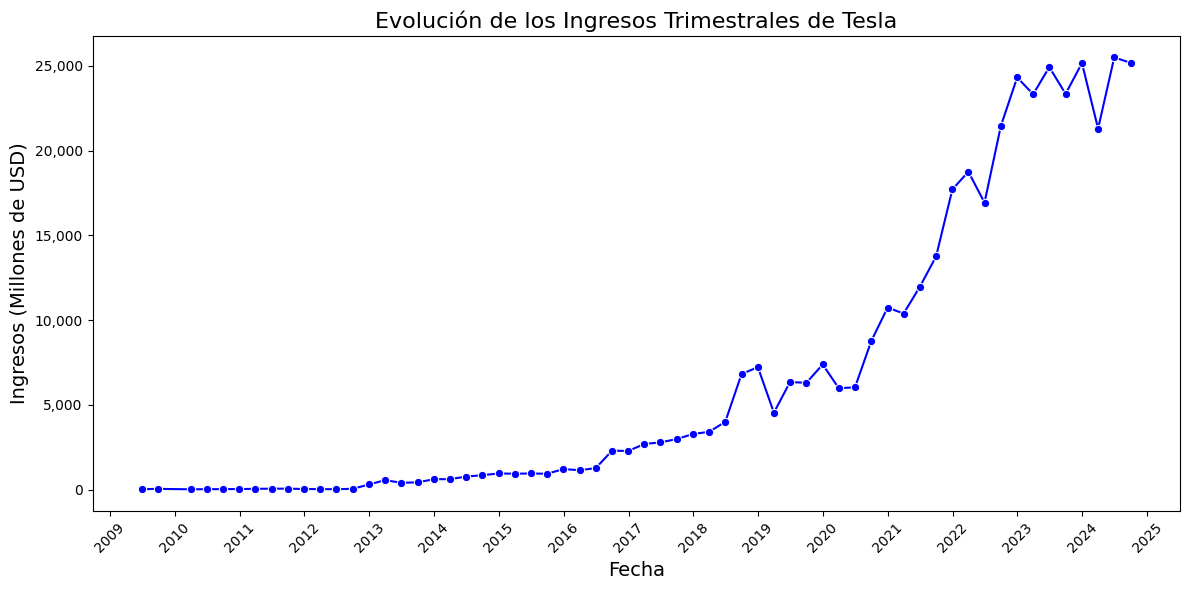

In [ ]:
# Gráfico de línea 

import matplotlib.dates as mdates

tesla_revenue_df["Date"] = pd.to_datetime(tesla_revenue_df["Date"])
tesla_revenue_df["Revenue"] = tesla_revenue_df["Revenue"].astype('int')

# Configuración del gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(data=tesla_revenue_df, x="Date", y="Revenue", marker="o", color="b")
plt.title("Evolución de los Ingresos Trimestrales de Tesla", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Ingresos (Millones de USD)", fontsize=14)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))  # Formato de miles en Y
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Intervalo anual en X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

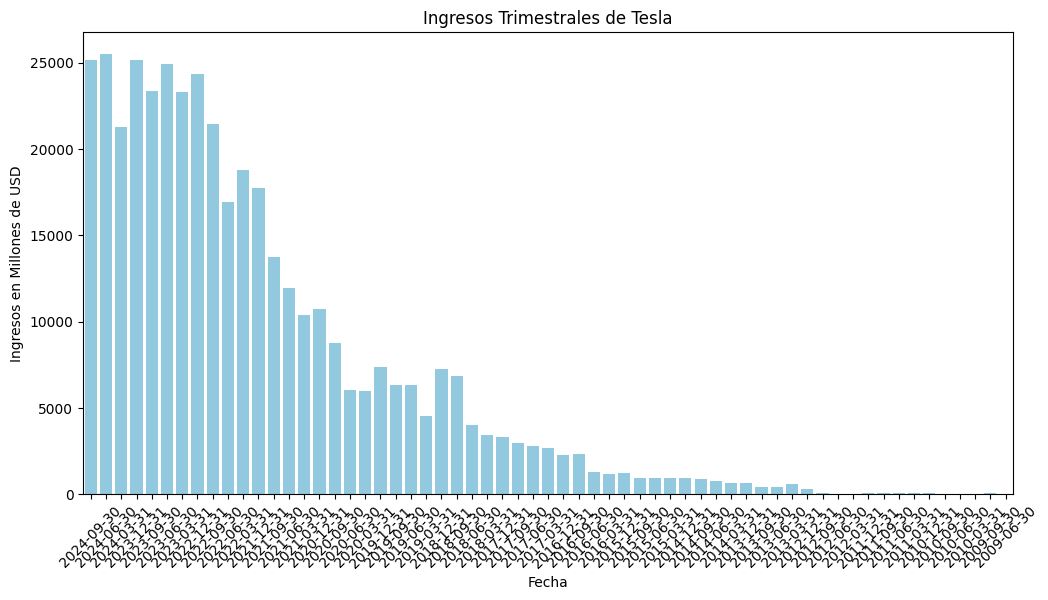

In [ ]:
# Gráfico de Barras

plt.figure(figsize=(12, 6))
sns.barplot(x="Date", y="Revenue", data=tesla_revenue_df, color="skyblue")
plt.title("Ingresos Trimestrales de Tesla")
plt.xlabel("Fecha")
plt.ylabel("Ingresos en Millones de USD")
plt.xticks(rotation=45)
plt.show()

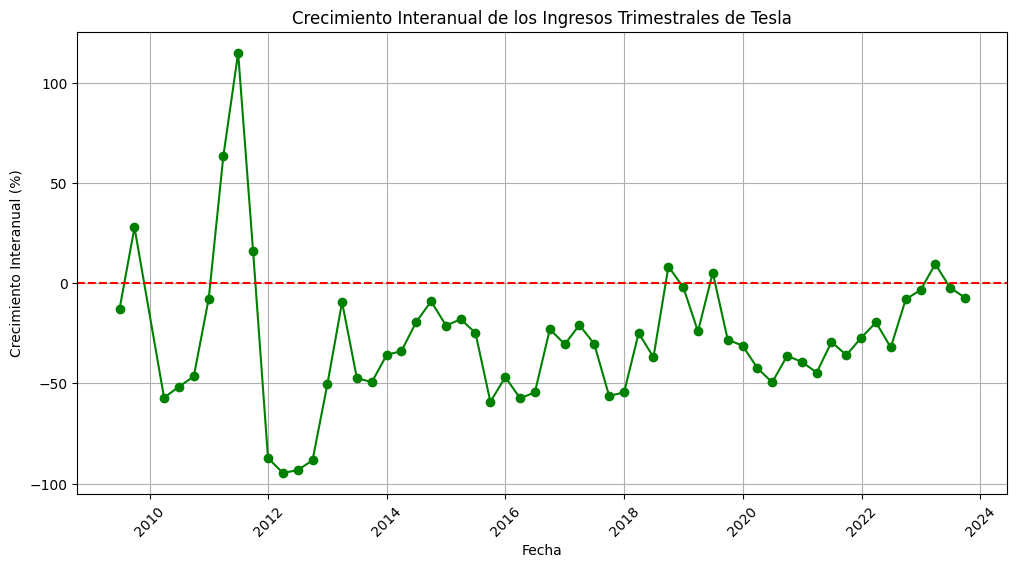

In [ ]:
# Gráfico de crecimiento interanual

tesla_revenue_df["Yearly Growth (%)"] = tesla_revenue_df["Revenue"].pct_change(periods=4) * 100

plt.figure(figsize=(12, 6))
plt.plot(tesla_revenue_df["Date"], tesla_revenue_df["Yearly Growth (%)"], marker='o', color='g')
plt.axhline(0, color='red', linestyle='--')  # Línea de referencia
plt.title("Crecimiento Interanual de los Ingresos Trimestrales de Tesla")
plt.xlabel("Fecha")
plt.ylabel("Crecimiento Interanual (%)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
